In [30]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
!pip install graphviz
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [31]:
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Levanto la data de los DFS

In [32]:
train_labels = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_labels.csv')
train_values = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_values.csv')
df_test = pd.read_csv('/content/drive/MyDrive/datasets_tp2/test_values.csv')



In [33]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [34]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0,0,0,0,0,0,0,0,0


Feature Engineering

Generamos el Target encode para P(damagegrade | glvlid)

In [36]:
df_values_with_damage = pd.merge(train_values, train_labels, on='building_id')
df_values_with_damage_encoded = pd.get_dummies(df_values_with_damage, columns =["damage_grade"])
#genero la prob de cada geo id por cada damage grade

for i in range(1, 4):
  encoder = ce.TargetEncoder(cols="geo_level_" +  str(i) +"_id")
  df_values_with_damage_encoded["prob1_geo" +  str(i)] = encoder.fit_transform(df_values_with_damage_encoded["geo_level_" +  str(i) +"_id"], df_values_with_damage_encoded["damage_grade_1"])
  df_values_with_damage_encoded["prob2_geo" +  str(i)] = encoder.fit_transform(df_values_with_damage_encoded["geo_level_" +  str(i) +"_id"], df_values_with_damage_encoded["damage_grade_2"])
  df_values_with_damage_encoded["prob3_geo" +  str(i)] = encoder.fit_transform(df_values_with_damage_encoded["geo_level_" +  str(i) +"_id"], df_values_with_damage_encoded["damage_grade_3"])

df_values_with_damage_encoded = df_values_with_damage_encoded.drop(columns=["damage_grade_1","damage_grade_2","damage_grade_3"])

train_values = df_values_with_damage_encoded

for k in range(1, 4):
  df_train_without_dp = train_values[["prob1_geo" + str(k),"prob2_geo"+ str(k),"prob3_geo"+ str(k),"geo_level_" + str(k) + "_id"]].drop_duplicates()
  df_test = df_test.merge(df_train_without_dp,on="geo_level_" + str(k) + "_id",how="left")
  df_test["prob1_geo" + str(k)] = df_test["prob1_geo" + str(k)].fillna(df_test["prob1_geo" + str(k)].mean())  
  df_test["prob2_geo" + str(k)] = df_test["prob2_geo" + str(k)].fillna(df_test["prob2_geo" + str(k)].mean()) 
  df_test["prob3_geo" + str(k)] = df_test["prob3_geo" + str(k)].fillna(df_test["prob3_geo" + str(k)].mean()) 

C:\Users\Pato\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Pato\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Pato\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Pato\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Pato\anaconda3\lib\site-packages\category_encoders\util

Usamos BinaryEncoder de los categoricos

In [37]:
df_train_encoding = pd.get_dummies(train_values, columns =['land_surface_condition', 'foundation_type', \
                            'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'])
df_test_encoding = pd.get_dummies(df_test, columns =['land_surface_condition', 'foundation_type', \
                            'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'])

Dropeamos las columnas que no suman importancia al resultado

In [38]:
 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_use_police"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_use_police"])

 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_health_post"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_health_post"])

 df_train_encoding=df_train_encoding.drop(columns=["geo_level_2_id","geo_level_3_id"])
 df_test_encoding=df_test_encoding.drop(columns=["geo_level_2_id","geo_level_3_id"])

In [39]:
df_train_encoding

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,2,30,6,5,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,28830,8,2,10,8,7,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,94947,21,2,10,5,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,590882,22,2,10,6,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,201944,11,3,30,8,9,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1,55,6,3,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
260597,669485,17,2,0,6,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
260598,602512,17,3,55,6,7,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
260599,151409,26,2,10,14,6,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [40]:
df_test_encoding

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,17,3,20,7,6,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,99355,6,2,25,13,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,890251,22,2,5,4,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,745817,26,1,0,19,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,421793,17,3,15,8,7,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,3,70,20,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
86864,663567,10,3,25,6,7,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0
86865,1049160,22,1,50,3,3,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
86866,442785,6,2,5,9,5,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Armamos y entrenamos el modelo XGBOOST y LGB

In [41]:
df_test_encoding = df_test_encoding.iloc[:,1:]
X = df_train_encoding.iloc[:, 1:]
y = train_labels.iloc[:, 1:]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [43]:
params_lgb = {
        "objective" : "multiclass",
        "num_class":3,
        "metric" : "multi_logloss",
        "boosting": 'gbdt',
        "max_depth" :9,
        "num_leaves" : 40,
        "learning_rate" : 0.05,
        "feature_fraction" : 0.5,
        "min_sum_hessian_in_leaf" : 0.1,
        "max_bin":8200,
        "verbosity" : 1,
        "num_threads":6,
        "seed": 1800
    }

In [44]:
lgb_cl = lgb.LGBMClassifier(**params_lgb,num_boost_round=1000)

In [45]:
xgb_cl = xgb.XGBClassifier(min_child_weight= 5, 
                           learning_rate= 0.1, 
                           gamma= 0.05, 
                           subsample= 0.8,
                           colsample_bytree= 0.3, 
                           colsample_bynode= 0.8,
                           colsample_bylevel= 0.8, 
                           max_depth = 20, 
                           n_estimators = 150)

Entrenamos el modelo ensamblado

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


vcl = VotingClassifier(
     estimators=[('xgb', xgb_cl), ('lgb', lgb_cl)],
     voting='hard')


vcl.fit(X_train, y_train)

C:\Users\Pato\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Pato\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:10:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Pato\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] num_threads is

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=0.8,
                                            colsample_bynode=0.8,
                                            colsample_bytree=0.3, gamma=0.05,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=20,
                                            min_child_weight=5, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=150, n_jobs=...
                                            scale_pos_weight=None,
                                            subsample=0.8, tree_method=None,
               

Muestro la importancia de las features

<BarContainer object of 73 artists>

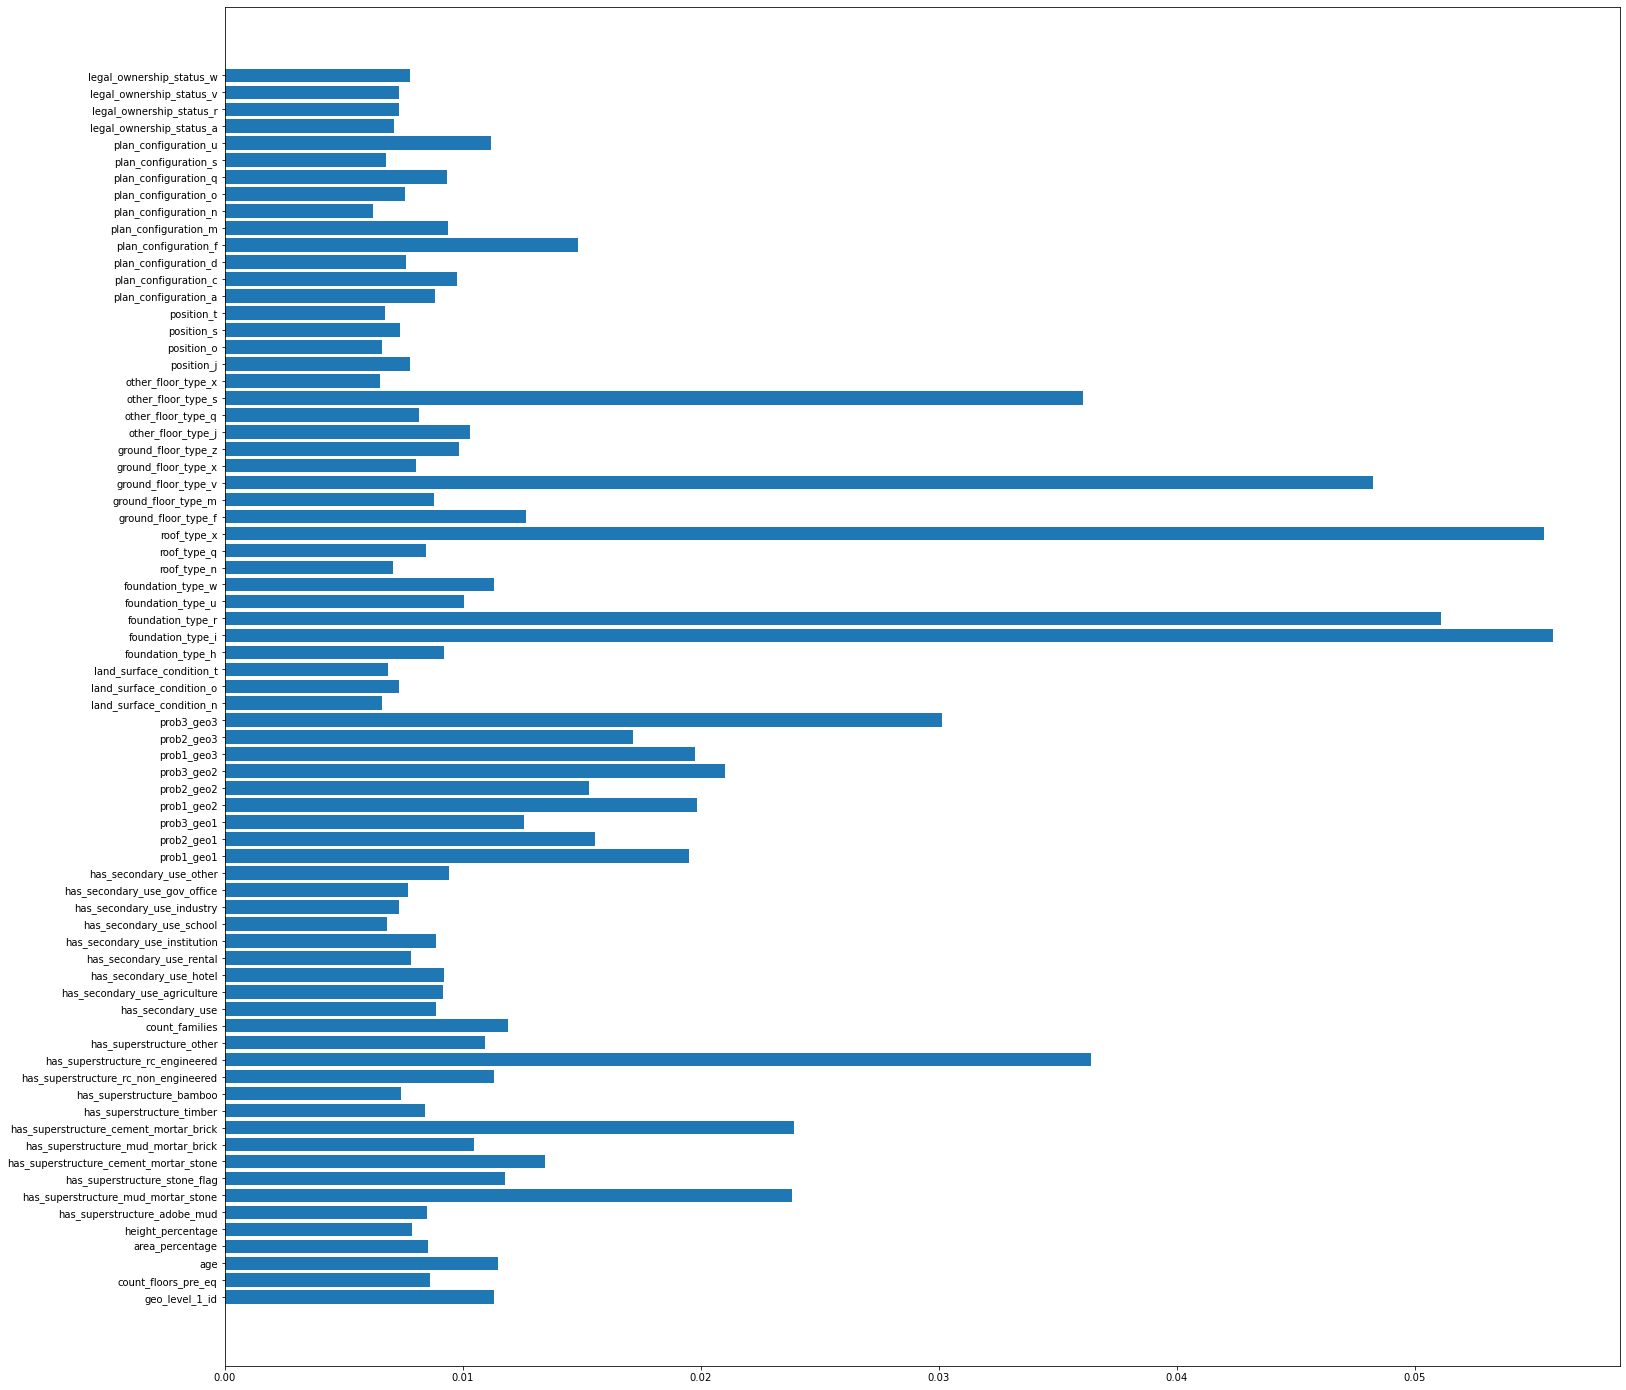

In [47]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, vcl.estimators_[0].feature_importances_)

<BarContainer object of 73 artists>

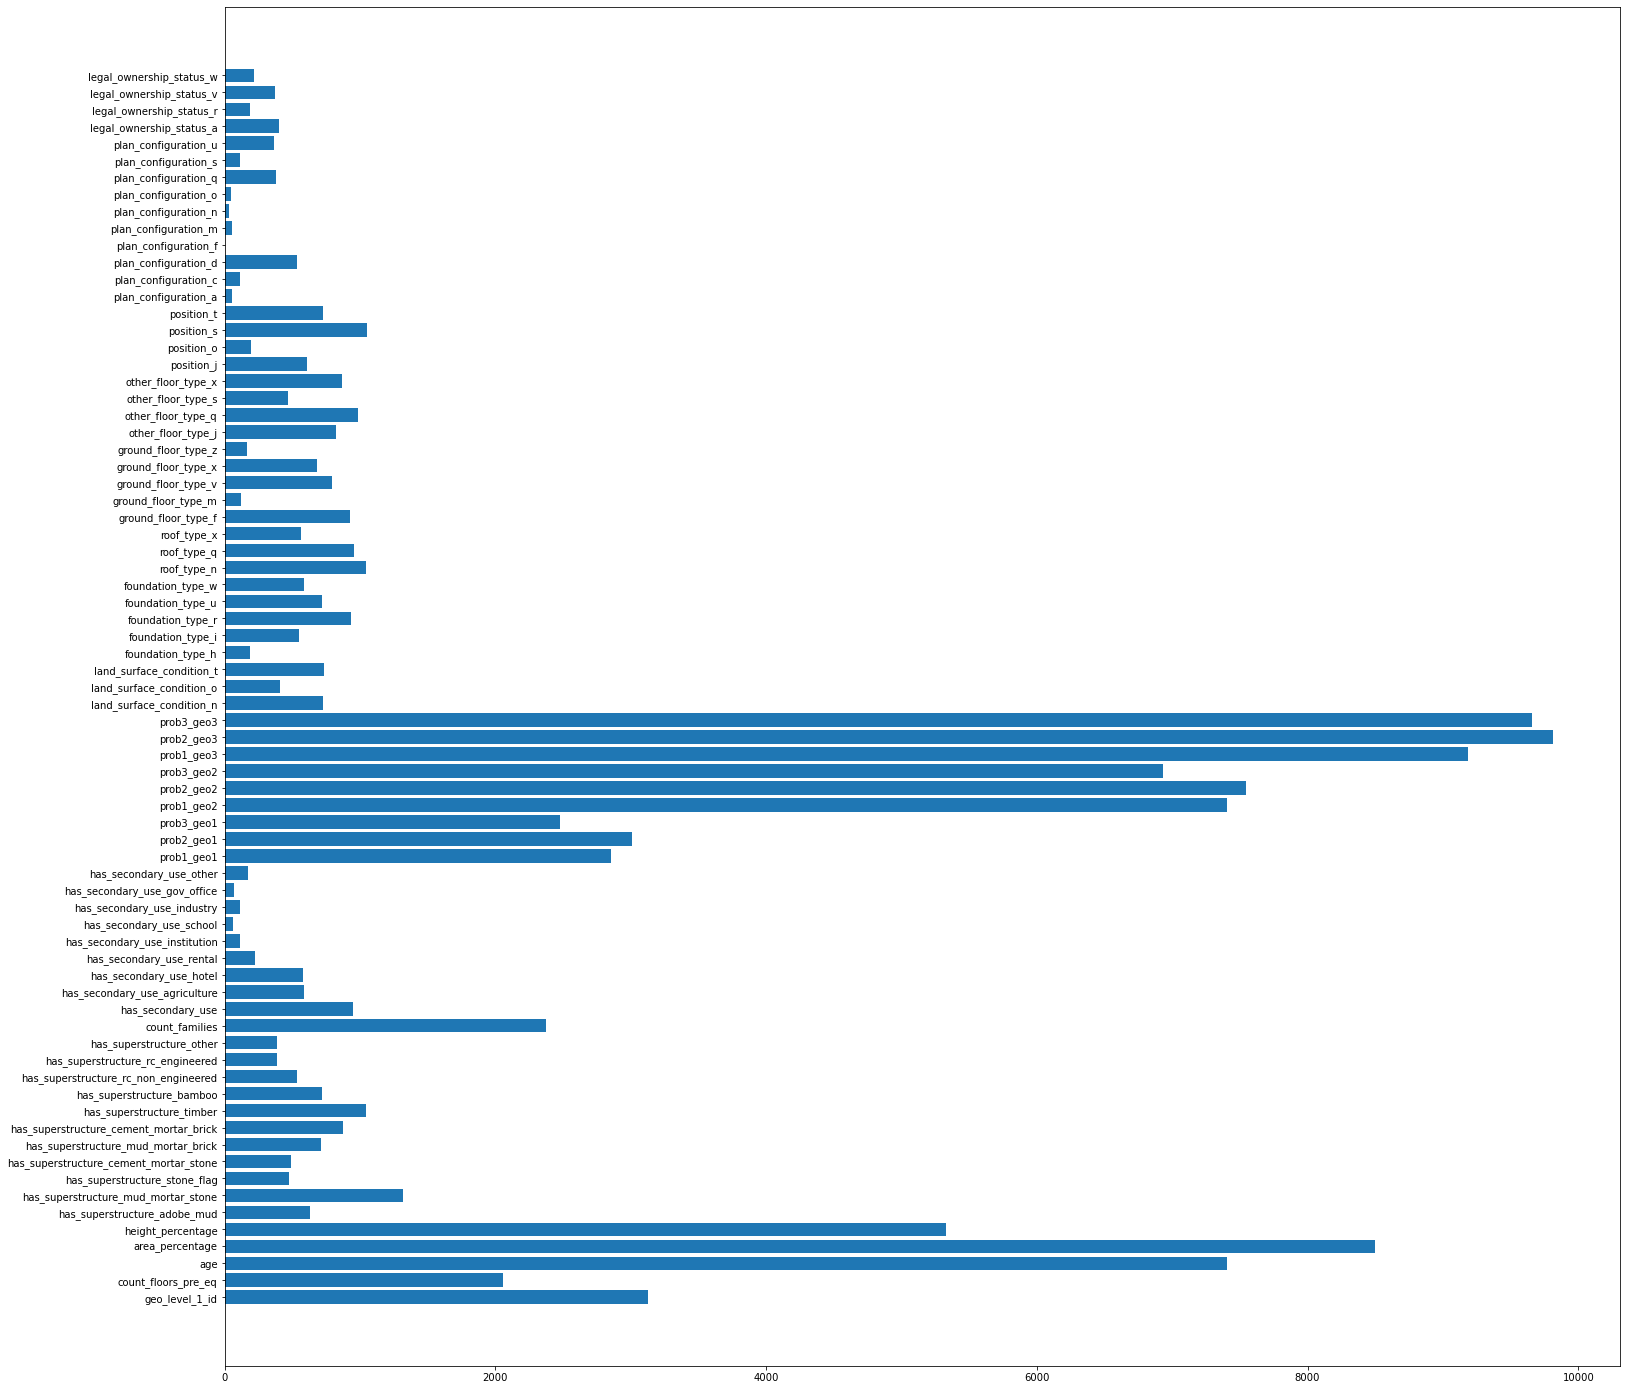

In [48]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, vcl.estimators_[1].feature_importances_)

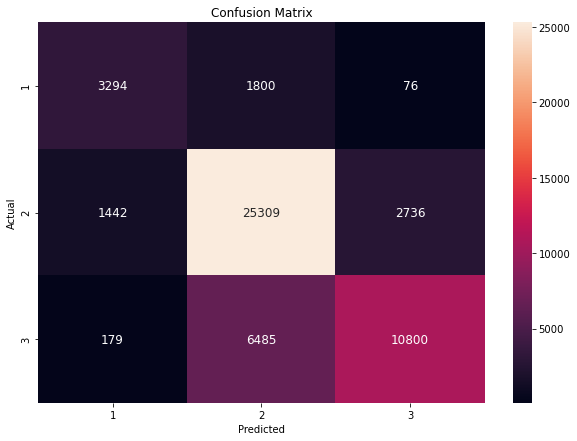

In [49]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in vcl.estimators_
], axis=0)

feature_importances


from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = vcl.predict(X_test)

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()


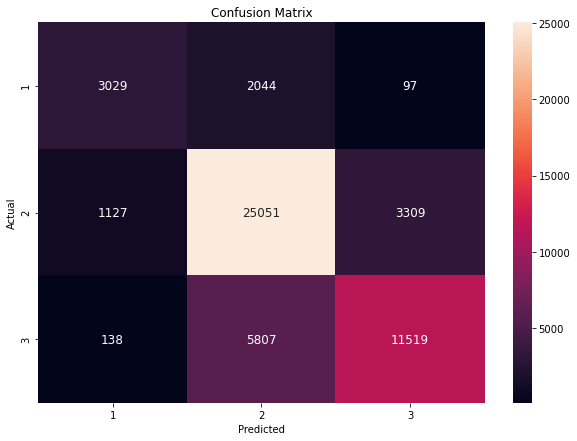

In [50]:
y_pred = vcl.estimators_[1].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()


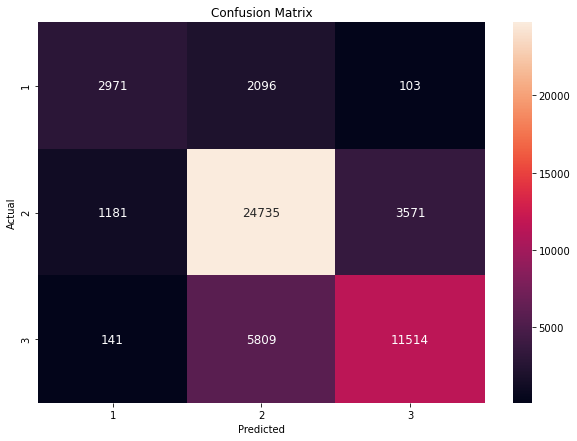

In [51]:
y_pred = vcl.estimators_[0].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()


hago el predict de los valores de test

In [52]:
pred_xgboost = vcl.predict(X_test)

In [53]:
f1_score(y_test, pred_xgboost, average ='micro')

0.7559908674046929

predigo el df_test y creo el file contra el format csv

In [54]:
pred_xgboost_final = vcl.predict(df_test_encoding)


In [55]:
pred_xgboost_final

array([3, 2, 3, ..., 2, 2, 1], dtype=int64)

In [56]:
submission_format = pd.read_csv('/content/drive/MyDrive/datasets_tp2/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=pred_xgboost_final,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [57]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [58]:
fecha = datetime.datetime.now(pytz.timezone("Etc/GMT+3"))
my_submission.to_csv('/content/drive/MyDrive/datasets_tp2/training-result.csv',index= True)